<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/6_Federated_Embedding_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Overview: https://www.tensorflow.org/federated

Image classification tutorial: https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification

# Installation

In [1]:
!pip install --quiet fastai==2.2.5
!pip install --quiet folium==0.2.1
!pip install --quiet imgaug==0.2.5
!pip install --quiet tensorflow==2.3.0
!pip install --quiet tensorflow_federated==0.17.0
!pip install --quiet --upgrade nest_asyncio

In [2]:
import nest_asyncio
nest_asyncio.apply()
%load_ext tensorboard

In [3]:
import collections
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import pandas as pd 
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import data

I dati vengono importati e poi splittati in train e test. 

In [5]:
data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data = mf.new_processing(data)
col_name = mf.get_col(data)

In [6]:
print('Rate safe/fraud:', (1/mf.ratio(data)).round(3))

Rate safe/fraud: 0.036


In [7]:
data, categorical_col_toemb, numerical_col = mf.labelEncoding(data, merge = True)
col_name = mf.get_col(data)

In [8]:
input_size = {}
for col in categorical_col_toemb:
  input_size[col] = int(data[col].max() + 1)

In [9]:
input_size

{'P_emaildomain': 61,
 'R_emaildomain': 62,
 'browser_name': 41,
 'device_name': 15,
 'device_version': 295,
 'os_name': 9}

In [32]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers

def underSampling(data, frac_under=0.3):
  from imblearn.under_sampling import RandomUnderSampler 
  us = RandomUnderSampler(sampling_strategy=frac_under, random_state=42)
  y = data['isFraud']
  X = data.drop(columns = ['isFraud'])
  X_us, y_us = us.fit_resample(X, y)
  return X_us, y_us

def overSampling(X, y = None, frac_over=0.4):
  from imblearn.over_sampling import SMOTE
  if y == None:
    y = X['isFraud']
    X = X.drop(columns=['isFraud'])
  sm = SMOTE(sampling_strategy=frac_over, random_state=42)
  X_sm, y_sm = sm.fit_resample(X, y)  
  return X_sm, y_sm

def rate(y):
  n_fraud = np.count_nonzero(y == 1)
  n_safe = np.shape(y)[0] - n_fraud
  return f'Rate safe/fraud: {n_safe/n_fraud}'

def get_keras_dataset(X, cols):
  df = pd.DataFrame(data=X, columns=cols)
  X = {str(col) : np.array(df[col]) for col in df.columns}
  return X

def get_server_data(data, frac=0.2):
  indici = np.arange(0,data.index[-1]+1, dtype=int)
  server_id = np.random.choice(indici, int(len(indici)*frac))
  client_id = [id for id in indici if id not in server_id]
  return data.iloc[server_id,:], data.iloc[client_id,:]

In [11]:
def server_embedding_model(data, input_size, epochs=20, performance=True):
  from sklearn.metrics import f1_score, recall_score, precision_score

  y = data['isFraud']
  X = data.drop(columns = ['isFraud'])
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
  X_train, y_train = overSampling(X_train, y_train)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

  keras.backend.clear_session()
  # Embedding for categorical features
  cols = mf.get_col(data)
  categorical_input = []
  numerical_input = []
  embeddings = []
  embedding_layer_names = []
  for col in categorical_col_toemb:
  # for col in categorical_col:
      _input = layers.Input(shape=[1], name=col)
      _embed = layers.Embedding(input_size[col], 3, name=col+'_emb')(_input)
      categorical_input.append(_input)
      embeddings.append(_embed)
      embedding_layer_names.append(col+'_emb')
      
  # Simple inputs for the numeric features
  for col in numerical_col:
      numeric_input = layers.Input(shape=(1,), name=col)
      numerical_input.append(numeric_input)
      
  # Merge the numeric inputs
  merged_num_inputs = layers.concatenate(numerical_input)

  # Merge embedding and use a Droput to prevent overfittting
  merged_inputs = layers.concatenate(embeddings)
  spatial_dropout = layers.SpatialDropout1D(0.6)(merged_inputs) # 0.2
  flat_embed = layers.Flatten()(spatial_dropout)

  # Merge embedding and numeric features
  all_features = layers.concatenate([flat_embed, merged_num_inputs])

  # MLP for classification
  x = layers.Dense(240, activation='relu')(all_features) #360
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.4)(x) 

  # Final model
  output = layers.Dense(1, activation='sigmoid')(x)
  model = models.Model(inputs=categorical_input + numerical_input, outputs=output)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
  print('***************************************************************')
  print('Model\'s training')
  history = model.fit(get_keras_dataset(X_train, cols), y_train, epochs=epochs, 
      batch_size=1024, validation_data=(get_keras_dataset(X_val, cols),y_val),
      verbose=1,shuffle = True , class_weight = {0: 0.5, 1: 4} )

  if performance:
    y_pred = model.predict(get_keras_dataset(X_test, cols))
    mf.plot_cm(y_test, y_pred, 'Blues')
    mf.plot_roc("ROC curve", y_test, y_pred,color='blue')
    print('***************************************************************')
    print('Model\'s performances')
    y_predicted = [1 if n >= 0.5 else 0 for n in y_pred ]
    print('F1 score: ',f1_score(y_test, y_predicted, average="binary"))
    print('Recall: ', recall_score(y_test, y_predicted, average='binary'))
    print('Precision: ', precision_score(y_test, y_predicted,  average='binary'))
  return model

In [12]:
server_data, client_data = get_server_data(data, frac=0.2)

***************************************************************
Model's training
Epoch 1/20
71/71 [==============================] - 4s 53ms/step - loss: 0.4068 - accuracy: 0.7308 - recall: 0.5909 - precision: 0.1017 - val_loss: 0.4364 - val_accuracy: 0.9547 - val_recall: 0.0845 - val_precision: 0.6333
Epoch 2/20
71/71 [==============================] - 2s 35ms/step - loss: 0.3297 - accuracy: 0.8700 - recall: 0.4758 - precision: 0.1782 - val_loss: 0.2807 - val_accuracy: 0.9545 - val_recall: 0.0489 - val_precision: 0.7432
Epoch 3/20
71/71 [==============================] - 2s 34ms/step - loss: 0.3135 - accuracy: 0.8843 - recall: 0.4790 - precision: 0.2015 - val_loss: 0.2712 - val_accuracy: 0.9542 - val_recall: 0.1557 - val_precision: 0.5435
Epoch 4/20
71/71 [==============================] - 2s 35ms/step - loss: 0.3064 - accuracy: 0.8905 - recall: 0.4846 - precision: 0.2146 - val_loss: 0.2605 - val_accuracy: 0.9496 - val_recall: 0.2536 - val_precision: 0.4378
Epoch 5/20
71/71 [=========

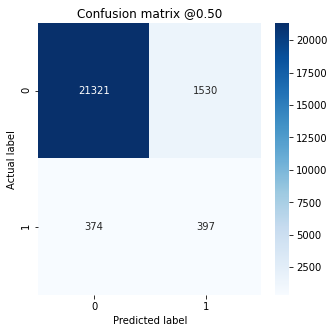

AUC:  0.8406548008155921
***************************************************************
Model's performances
F1 score:  0.2942920681986657
Recall:  0.5149156939040207
Precision:  0.2060197197716658


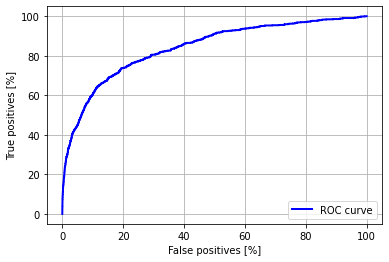

In [13]:
server_model = server_embedding_model(server_data, input_size)

Estrarre i layer di embedding e trasformare i dati. 

In [23]:
def client_data_embedding(data, server_model):
  embeddings = {}
  for i in range(6,12):
    embeddings[server_model.layers[i].name[:-4]] = server_model.layers[i].get_weights()[0] #https://stackoverflow.com/questions/51235118/how-to-get-word-vectors-from-keras-embedding-layer
  new_data = data.copy()
  new_cols = []
  for col in categorical_col_toemb:
    for i in range(1,4):
      new_col = col + '_'+str(i)
      new_cols.append(new_col)
  x = {}
  for i in new_cols:
    x[i] = {}
  for col in x:
    for i in range(len(embeddings[col[:-2]])):
      j = int(col[-1])
      x[col][i+1] = embeddings[col[:-2]][i][j-1]
  for col in x:
    new_data[col] = new_data[col[:-2]]
  for col in x:
    new_data[col].replace(to_replace=x[col], inplace=True)
  return new_data

In [25]:
client_data_embedded = client_data_embedding(client_data, server_model)

In [28]:
train_data, test_data = train_test_split(client_data_embedded, test_size=0.1)

In [29]:
# X, y = underSampling(train_data)
# rate(y)

In [33]:
X, y = overSampling(train_data)
rate(y)

'Rate safe/fraud: 20.000905063592626'

In [35]:
cols = mf.get_col(client_data_embedded)
train_data = mf.mergeResult(X, y, cols)

In [36]:
print('Dataset size:', train_data.shape[0])

Dataset size: 440872


In [37]:
del client_data_embedded, client_data, server_data, X, y

# Convert data

Il dataset deve essere convertito in un tensore, con componenti (feature_vector, label). 

In [40]:
def to_tensor(data, cols, n_clients = 5):
  shuffled = data.sample(frac=1)
  result = np.array_split(shuffled, n_clients)  

  res = []
  label = []

  for dataset in result:
    label.append(dataset['isFraud'])
    res.append(dataset.drop(columns = ['isFraud']))

  dataset = {}
  for i in range(n_clients):
    dataset[i] = tf.data.Dataset.from_tensor_slices((res[i], label[i]))

  return dataset

In [41]:
dataset = to_tensor(train_data, cols)
test_set = to_tensor(test_data, cols)

In [ ]:
# del train_data, test_data

# Federated data

Si definisce la funzione di preprocessing del dataset, che serve a creare l'OrderedDict, su cui si andranno a creare le batch necessarie per il training del modello. 

In [ ]:
NUM_CLIENTS = 5
NUM_EPOCHS = 10
BATCH_SIZE = 500 #250
SHUFFLE_BUFFER = 10
PREFETCH_BUFFER = 10

def preprocess(dataset):
  def batch_format_fn(e1, e2):
    return collections.OrderedDict(
        x = tf.cast(e1, tf.float32),
        y = tf.cast(e2, tf.int32))
  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

preprocessed_example_dataset = preprocess(dataset[0])
# sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_example_dataset)))
# sample_batch

I dati federati sono una lista di dataset divisi per cliente. 

In [44]:
def make_federated_data(dataset):
  federated = []
  for i in dataset:
    federated.append(preprocess(dataset[i]))
  return federated

federated_train_data = make_federated_data(dataset)

print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

Number of client datasets: 5
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 280)), (y, (None,))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


In [ ]:
# del dataset

# Model creation and training

Creazione della rete neurale che sarà trainata. 

Viene anche definita la model function, in cui si specifica il modello, il tipo di input, la loss e le metriche da utilizzare. 

Infine si costruisce il processo di averaging, specificando l'optimizer da usare, cioè SGD, e il learning rate del server e del client. 

In [50]:
test_set

{0: <TensorSliceDataset shapes: ((280,), ()), types: (tf.float32, tf.float32)>,
 1: <TensorSliceDataset shapes: ((280,), ()), types: (tf.float32, tf.float32)>,
 2: <TensorSliceDataset shapes: ((280,), ()), types: (tf.float32, tf.float32)>,
 3: <TensorSliceDataset shapes: ((280,), ()), types: (tf.float32, tf.float32)>,
 4: <TensorSliceDataset shapes: ((280,), ()), types: (tf.float32, tf.float32)>}

In [53]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, BatchNormalization

def create_keras_model():
  model = Sequential()
  model.add(Input(shape=(280,)))   
  model.add(Dense(360, activation='relu')) 
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  return model

def model_fn():
  soglia = 0.5
  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss= tf.keras.losses.BinaryCrossentropy(),#tf.nn.weighted_cross_entropy_with_logits(tf.one_hot(labels, 2), logits, pos_weight=4),
      metrics=[tf.keras.metrics.BinaryAccuracy(), 
               tf.keras.metrics.Recall(thresholds=soglia),
               tf.keras.metrics.Precision(thresholds=soglia)])
  
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,  
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.5), #0.05
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1)) 

Training del modello. 

In [46]:
NUM_ROUNDS = 20
state = iterative_process.initialize()
for round_num in range(1, NUM_ROUNDS + 1):
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num, metrics))

round  1, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('binary_accuracy', 0.9482663), ('recall', 0.015114562), ('precision', 0.12957367), ('loss', 0.21446028)]))])
round  2, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('binary_accuracy', 0.95096505), ('recall', 0.0073643597), ('precision', 0.16559555), ('loss', 0.17588595)]))])
round  3, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('binary_accuracy', 0.95167166), ('recall', 0.0041728197), ('precision', 0.1795082), ('loss', 0.17043273)]))])
round  4, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('binary_accuracy', 0.95190

KeyboardInterrupt: ignored

# Model evaluation

Evaluation del modello sui test data. 

In [ ]:
evaluation = tff.learning.build_federated_evaluation(model_fn)
train_metrics = evaluation(state.model, federated_train_data)

In [ ]:
federated_test_data = make_federated_data(test_set)

(<tf.Tensor 'args_0:0' shape=(None,) dtype=float32>, <tf.Tensor 'args_1:0' shape=(None,) dtype=float32>, <tf.Tensor 'args_2:0' shape=(None,) dtype=float32>, <tf.Tensor 'args_3:0' shape=(None,) dtype=float32>, <tf.Tensor 'args_4:0' shape=(None,) dtype=float32>, <tf.Tensor 'args_5:0' shape=(None,) dtype=float32>, <tf.Tensor 'args_6:0' shape=(None,) dtype=float32>, <tf.Tensor 'args_7:0' shape=(None,) dtype=float32>, <tf.Tensor 'args_8:0' shape=(None,) dtype=float32>, <tf.Tensor 'args_9:0' shape=(None,) dtype=float32>, <tf.Tensor 'args_10:0' shape=(None,) dtype=float32>, <tf.Tensor 'args_11:0' shape=(None,) dtype=float32>, <tf.Tensor 'args_12:0' shape=(None,) dtype=float32>, <tf.Tensor 'args_13:0' shape=(None,) dtype=float32>, <tf.Tensor 'args_14:0' shape=(None,) dtype=float32>, <tf.Tensor 'args_15:0' shape=(None,) dtype=float32>, <tf.Tensor 'args_16:0' shape=(None,) dtype=float32>, <tf.Tensor 'args_17:0' shape=(None,) dtype=float32>, <tf.Tensor 'args_18:0' shape=(None,) dtype=float32>, <t

In [ ]:
test_metrics = evaluation(state.model, federated_test_data)
str(test_metrics)

"OrderedDict([('binary_accuracy', 0.9652067), ('recall', 0.0), ('precision', 0.0), ('loss', 0.15449838)])"

Board di tensorboad, per visualizzare la loss e le metriche in modo interattivo. 

In [ ]:
# logdir = "/tmp/logs/scalars/training/"
# summary_writer = tf.summary.create_file_writer(logdir)
# state = iterative_process.initialize()
# with summary_writer.as_default():
#   for round_num in range(1, NUM_ROUNDS):
#     state, metrics = iterative_process.next(state, federated_train_data)
#     for name, value in metrics['train'].items():
#       tf.summary.scalar(name, value, step=round_num)

In [ ]:
# !ls {logdir}
# %tensorboard --logdir {logdir} --port=0